In [8]:
import os

# Define the correct paths to the landslide and non-landslide images
landslide_dir = '/content/drive/MyDrive/landslides-20241028T061823Z-001'
nonlandslide_dir = '/content/drive/MyDrive/non-landslide-20241028T060700Z-001'

# Function to count the number of images in a folder
def count_images_in_folder(folder_path):
    valid_images = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    return len([f for f in os.listdir(folder_path) if f.lower().endswith(tuple(valid_images))])

# Count images in landslide folder
num_landslide_images = count_images_in_folder(landslide_dir)
print(f"Number of images in 'landslide' folder: {num_landslide_images}")

# Count images in non-landslide folder
num_nonlandslide_images = count_images_in_folder(nonlandslide_dir)
print(f"Number of images in 'non-landslide' folder: {num_nonlandslide_images}")


Number of images in 'landslide' folder: 779
Number of images in 'non-landslide' folder: 657


In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import shutil

# Correct paths for landslide and non-landslide images
landslide_dir = '/content/drive/MyDrive/landslides-20241028T061823Z-001'
nonlandslide_dir = '/content/drive/MyDrive/non-landslide-20241028T060700Z-001'

# Create directories for augmented images
base_augmented_dir = '/content/augmented_images'
augmented_landslide_dir = os.path.join(base_augmented_dir, 'landslide')
augmented_nonlandslide_dir = os.path.join(base_augmented_dir, 'nonlandslide')

os.makedirs(augmented_landslide_dir, exist_ok=True)
os.makedirs(augmented_nonlandslide_dir, exist_ok=True)

# Image settings
IMG_SIZE = (256, 256)

# Create an instance of the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to preprocess images (resize and normalize)
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Resize image
    img_array = img_to_array(img)  # Convert image to array
    img_array = img_array / 255.0  # Normalize pixel values (0-1)
    return img_array

# Function to augment images until the target count is reached
def augment_images(input_dir, output_dir, target_count):
    current_images = os.listdir(input_dir)
    num_current_images = len(current_images)
    num_to_generate = target_count - num_current_images

    if num_to_generate <= 0:
        print(f"No augmentation needed, already have {num_current_images} images.")
        return

    print(f"Augmenting {num_to_generate} images in folder: {input_dir}")

    # Augment until we reach the target number of images
    i = 0
    for img_name in current_images:
        img_path = os.path.join(input_dir, img_name)
        # Preprocess image
        img_array = preprocess_image(img_path)
        img_array = np.expand_dims(img_array, axis=0)

        # Generate batches of augmented images
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= num_to_generate:
                break

# Preprocess and augment landslide images to reach 3000 images
augment_images(landslide_dir, augmented_landslide_dir, target_count=3000)

# Preprocess and augment non-landslide images to reach 2500 images
augment_images(nonlandslide_dir, augmented_nonlandslide_dir, target_count=2500)

print("Preprocessing and augmentation completed.")



Augmenting 2221 images in folder: /content/drive/MyDrive/landslides-20241028T061823Z-001
Augmenting 1843 images in folder: /content/drive/MyDrive/non-landslide-20241028T060700Z-001
Preprocessing and augmentation completed.


Found 6727 images belonging to 2 classes.
Found 1681 images belonging to 2 classes.
Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.9030 - loss: 1.7325 - val_accuracy: 0.6376 - val_loss: 0.8660
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9062 - loss: 0.6944 - val_accuracy: 0.6471 - val_loss: 0.8186
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.9444 - loss: 0.4609 - val_accuracy: 0.9285 - val_loss: 0.2008
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step - accuracy: 1.0000 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0750
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9551 - loss: 0.1611 - val_accuracy: 0.9513 - val_loss: 0.1362
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 150us/step - accuracy: 0.9688 - loss: 0.0511 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.9539 - loss: 0.1317 - val_accuracy: 0.9615 - val_loss: 0.1112
Epoch 

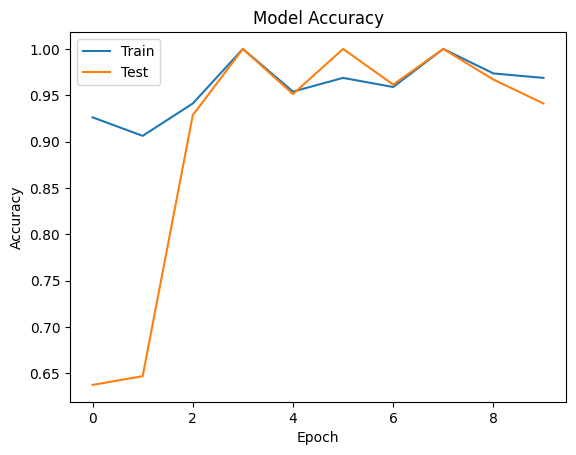

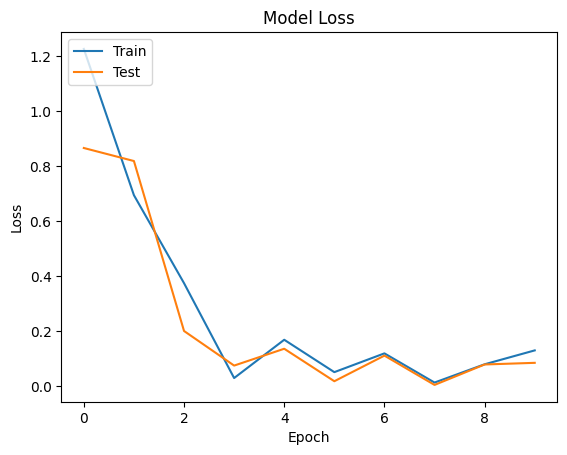

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define image size and batch size
image_size = (256, 256)
batch_size = 32

# Data augmentation and rescaling for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    validation_split=0.2      # 80% for training, 20% for validation
)

# Training data generator
train_generator = datagen.flow_from_directory(
    base_augmented_dir,  # Updated path for augmented images
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Training subset
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    base_augmented_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Validation subset
)

# Define the CNN model (same as before)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10  # Adjust as necessary
)

# Evaluate the model
evaluation = model.evaluate(validation_generator)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50, EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define image size and batch size
image_size = (256, 256)
batch_size = 32

# Data augmentation and rescaling for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data generator
train_generator = datagen.flow_from_directory(
    base_augmented_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    base_augmented_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Define your CNN model (MyModel)
def create_my_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile and train MyModel
MyModel = create_my_model()
MyModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_my_model = MyModel.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Function to evaluate a model and return metrics
def evaluate_model(model, validation_generator):
    y_true = validation_generator.classes
    y_pred = (model.predict(validation_generator) > 0.5).astype("int32")

    report = classification_report(y_true, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate IoU
    TP = conf_matrix[1, 1]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]

    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    overall_accuracy = (TP + TN) / (TP + TN + FP + FN)
    IoU_class_0 = TN / (TN + FP + FN)  # IoU for Class 0
    IoU_class_1 = TP / (TP + FP + FN)  # IoU for Class 1
    mean_IoU = (IoU_class_0 + IoU_class_1) / 2  # Mean IoU

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Overall Accuracy (OA)': overall_accuracy,
        'IoU (Class 0)': IoU_class_0,
        'IoU (Class 1)': IoU_class_1,
        'Mean IoU (mIoU)': mean_IoU,
        'Confusion Matrix': conf_matrix
    }

# Create a dictionary of models
models = {
    "MyModel": MyModel,
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
}

# Function to compile and train transfer learning models
def compile_and_train_model(base_model):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=10
    )
    return model, history

# Evaluate each model and store metrics
results = {}
for model_name, model in models.items():
    if model_name == "MyModel":
        results[model_name] = evaluate_model(model, validation_generator)
    else:
        transfer_model, history = compile_and_train_model(model)
        results[model_name] = evaluate_model(transfer_model, validation_generator)

# Prepare results for DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print comparison table
print(results_df)

# Plot confusion matrices and graphs
for model_name, metrics in results.items():
    conf_matrix = metrics['Confusion Matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot accuracy and loss for MyModel
plt.figure(figsize=(12, 6))
plt.plot(history_my_model.history['accuracy'], label='Train Accuracy (MyModel)')
plt.plot(history_my_model.history['val_accuracy'], label='Validation Accuracy (MyModel)')
plt.title('MyModel Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_my_model.history['loss'], label='Train Loss (MyModel)')
plt.plot(history_my_model.history['val_loss'], label='Validation Loss (MyModel)')
plt.title('MyModel Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy and loss for transfer models
for model_name in models.keys():
    if model_name != "MyModel":
        plt.figure(figsize=(12, 6))
        plt.plot(results[model_name]['accuracy'], label='Train Accuracy (' + model_name + ')')
        plt.plot(results[model_name]['val_accuracy'], label='Validation Accuracy (' + model_name + ')')
        plt.title(f'{model_name} Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(results[model_name]['loss'], label='Train Loss (' + model_name + ')')
        plt.plot(results[model_name]['val_loss'], label='Validation Loss (' + model_name + ')')
        plt.title(f'{model_name} Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()


Found 6727 images belonging to 2 classes.
Found 1681 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/210 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.9150 - loss: 2.0905 - val_accuracy: 0.7350 - val_loss: 0.9348
Epoch 2/10
  1/210 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 1.0000 - loss: 0.0131

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.7059 - val_loss: 0.8704
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9452 - loss: 0.6936 - val_accuracy: 0.9014 - val_loss: 0.5605
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8824 - val_loss: 1.3742
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9598 - loss: 0.2867 - val_accuracy: 0.9645 - val_loss: 0.1764
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 139us/step - accuracy: 0.9688 - loss: 0.1059 - val_accuracy: 0.8824 - val_loss: 0.6478
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9643 - loss: 0.1596 - val_accuracy: 0.9573 - val_loss: 0.1072
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 133us/step - accuracy: 0.9375 - loss: 0.3293 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 9/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9640 - loss: 0.1356 - val_accuracy:

<ipython-input-13-7f2db56f2c57>:108: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 111s 274ms/step - accuracy: 0.9379 - loss: 0.1538 - val_accuracy: 0.5319 - val_loss: 31.3037
Epoch 2/10
  1/210 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.9375 - loss: 0.3564

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9375 - loss: 0.3564 - val_accuracy: 0.5882 - val_loss: 27.8644
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 83s 152ms/step - accuracy: 0.9717 - loss: 0.0938 - val_accuracy: 0.5679 - val_loss: 1.1785
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - accuracy: 1.0000 - loss: 0.0315 - val_accuracy: 0.6471 - val_loss: 1.0227
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step - accuracy: 0.9822 - loss: 0.0510 - val_accuracy: 0.6989 - val_loss: 1.6134
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - accuracy: 0.9688 - loss: 0.0577 - val_accuracy: 0.5882 - val_loss: 1.6915
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9884 - loss: 0.0345 - val_accuracy: 0.9357 - val_loss: 0.2134
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - accuracy: 0.9688 - loss: 0.1356 - val_accuracy: 0.9412 - val_loss: 0.4881
Epoch 9/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.9849 - loss: 0.0458 - val_acc

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


210/210 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9375 - loss: 0.2273 - val_accuracy: 0.9412 - val_loss: 0.0899
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 124s 591ms/step - accuracy: 0.9228 - loss: 0.1911 - val_accuracy: 0.9423 - val_loss: 0.1439
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - accuracy: 0.8750 - loss: 0.1823 - val_accuracy: 1.0000 - val_loss: 0.0960
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 141s 592ms/step - accuracy: 0.9270 - loss: 0.1661 - val_accuracy: 0.9477 - val_loss: 0.1301
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.9062 - loss: 0.1604 - val_accuracy: 1.0000 - val_loss: 0.0618
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 141s 592ms/step - accuracy: 0.9329 - loss: 0.1567 - val_accuracy: 0.9549 - val_loss: 0.1061
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9062 - loss: 0.1329 - val_accuracy: 0.8824 - val_loss: 0.1273
Epoch 9/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 141s 596ms/step - accuracy: 0.9467 - loss: 0.1315 - val_a